# 🎧 Blind Source Separation (BSS) Two prople


## 1 FastICA Implementation


C:\Users\86137\AppData\Local\Temp\ipykernel_23568\2171836136.py:49: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, perm = bss_eval_sources(sources, S_est)


ICA 分离评估指标：
  源 1: SDR=40.16 dB, SIR=40.19 dB, SAR=62.16 dB
  源 2: SDR=55.88 dB, SIR=59.34 dB, SAR=58.49 dB


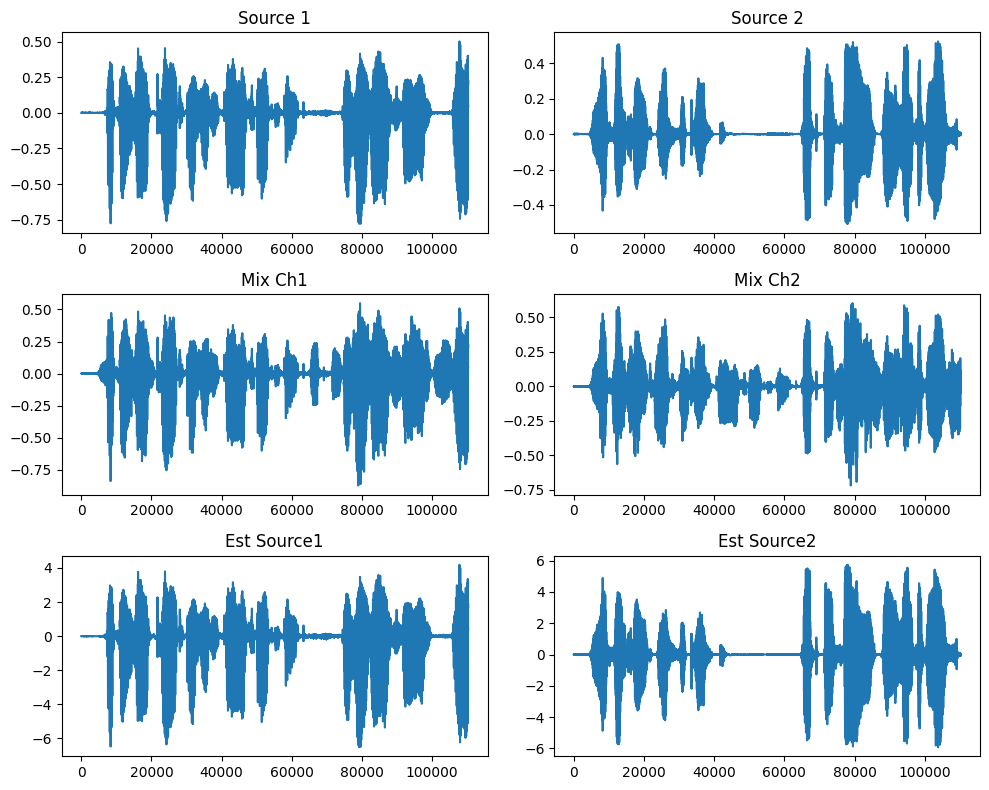

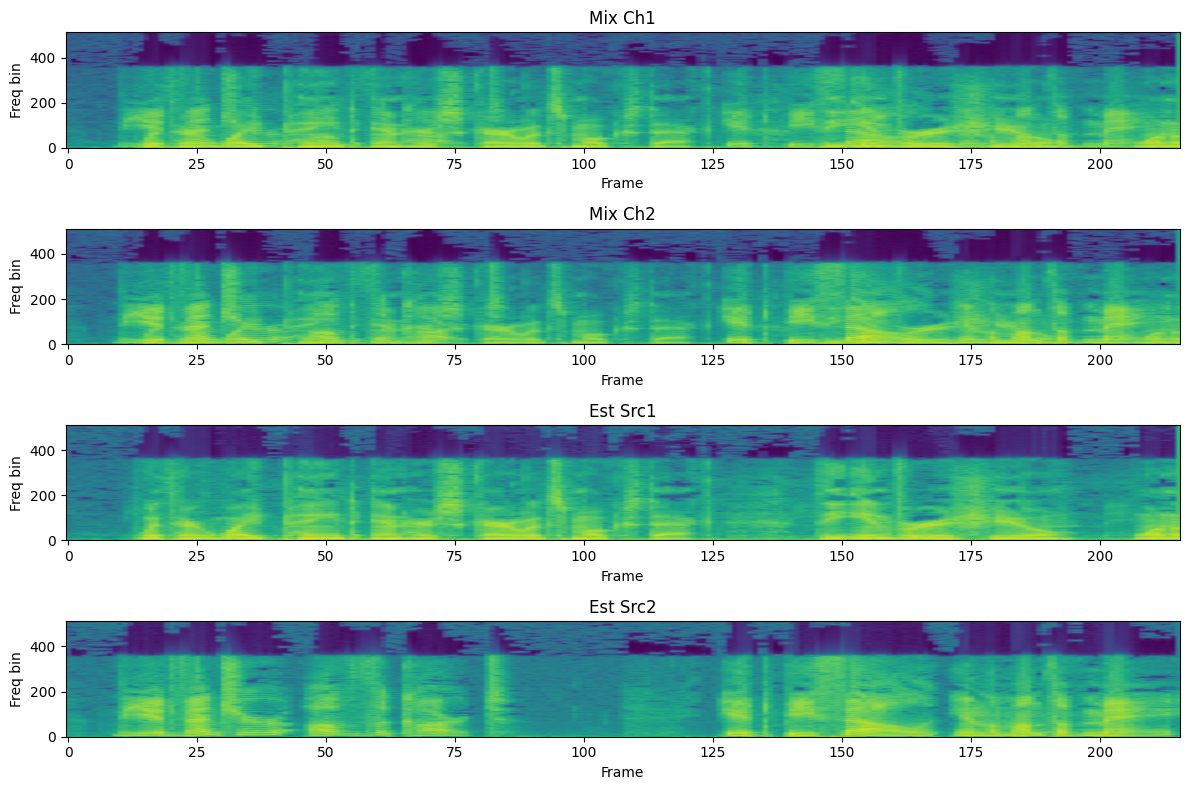

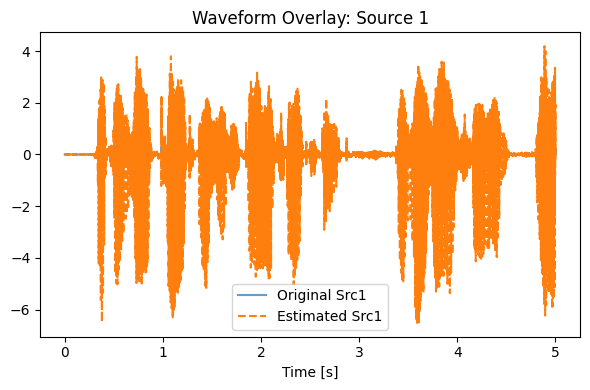

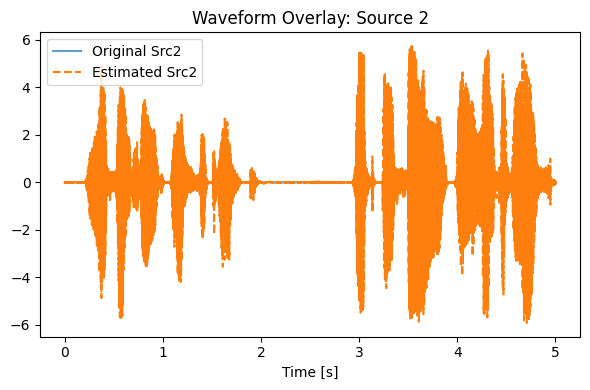

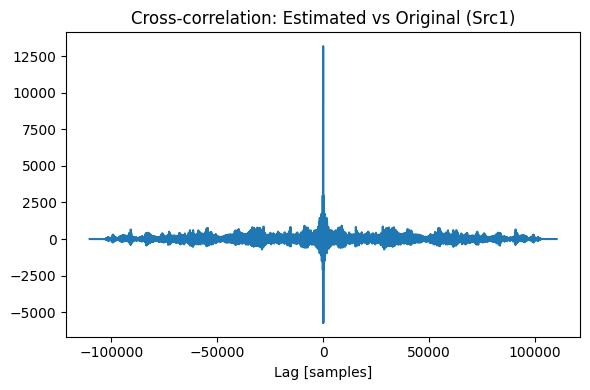

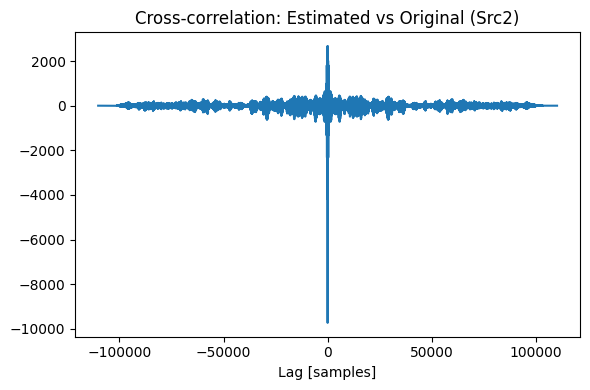

分离结果已保存到 c:\Users\86137\Desktop\123project\results\separated


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from sklearn.decomposition import FastICA
from mir_eval.separation import bss_eval_sources
import os
from scipy.signal import correlate
import sys

import numpy as np
import librosa

def stft(x, n_fft=1024, hop_length=None):
    """
    Compute the STFT of a 1D signal.
    """
    hop_length = hop_length or n_fft // 2
    return librosa.stft(x, n_fft=n_fft, hop_length=hop_length)


def istft(X, hop_length=None):
    """
    Inverse STFT back to time-domain signal.
    """
    hop_length = hop_length or (X.shape[0] * 2)
    return librosa.istft(X, hop_length=hop_length)
def main():
    
    s1, sr1 = librosa.load(librosa.example('libri1'), duration=5.0)
    s2, sr2 = librosa.load(librosa.example('libri2'), duration=5.0)
    assert sr1 == sr2
    
    L = min(len(s1), len(s2))
    s1, s2 = s1[:L], s2[:L]
    sources = np.vstack([s1, s2])   # shape = (2, L)


    A = np.array([[1.0, 0.5],
                  [0.5, 1.0]])
    X = A @ sources                # shape = (2, L)

   
    ica = FastICA(n_components=2, random_state=0)
    S_est = ica.fit_transform(X.T).T  # shape = (2, L)

  
    sdr, sir, sar, perm = bss_eval_sources(sources, S_est)
    print("ICA evaluation:")
    for i,(sdr_i, sir_i, sar_i) in enumerate(zip(sdr, sir, sar), 1):
        print(f"  source {i}: SDR={sdr_i:.2f} dB, SIR={sir_i:.2f} dB, SAR={sar_i:.2f} dB")

    
    plt.figure(figsize=(10, 8))
    titles = ['Source 1','Source 2','Mix Ch1','Mix Ch2','Est Source1','Est Source2']
    signals = [s1, s2, X[0], X[1], S_est[0], S_est[1]]
    for idx, sig in enumerate(signals, 1):
        plt.subplot(3, 2, idx)
        plt.plot(sig)
        plt.title(titles[idx-1])
        plt.tight_layout()
    plt.show()

  
    plt.figure(figsize=(12, 8))
    items = [(X[0], 'Mix Ch1'), (X[1], 'Mix Ch2'),
             (S_est[0], 'Est Src1'), (S_est[1], 'Est Src2')]
    for idx, (sig, title) in enumerate(items, 1):
        plt.subplot(4, 1, idx)
        D = stft(sig, n_fft=1024, hop_length=512)
        plt.imshow(20 * np.log10(np.abs(D) + 1e-6),
                   origin='lower', aspect='auto')
        plt.title(title)
        plt.ylabel('Freq bin')
        plt.xlabel('Frame')
    plt.tight_layout()
    plt.show()

 
    plt.figure(figsize=(6, 4))
    t = np.arange(L) / sr1
    plt.plot(t, s1, label='Original Src1', alpha=0.7)
    plt.plot(t, S_est[0], '--', label='Estimated Src1')
    plt.title('Waveform Overlay: Source 1')
    plt.xlabel('Time [s]')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    t = np.arange(L) / sr2
    plt.plot(t, s2, label='Original Src2', alpha=0.7)
    plt.plot(t, S_est[1], '--', label='Estimated Src2')
    plt.title('Waveform Overlay: Source 2')
    plt.xlabel('Time [s]')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5.4Cross-correlation for Src1
    corr = correlate(S_est[0], s1, mode='full')
    lags = np.arange(-L+1, L)
    plt.figure(figsize=(6, 4))
    plt.plot(lags, corr)
    plt.title('Cross-correlation: Estimated vs Original (Src1)')
    plt.xlabel('Lag [samples]')
    plt.tight_layout()
    plt.show()

    corr = correlate(S_est[1], s2, mode='full')
    lags = np.arange(-L+1, L)
    plt.figure(figsize=(6, 4))
    plt.plot(lags, corr)
    plt.title('Cross-correlation: Estimated vs Original (Src2)')
    plt.xlabel('Lag [samples]')
    plt.tight_layout()
    plt.show()


  
    out_dir = os.path.abspath(os.path.join('.', 'results', 'separated'))

    os.makedirs(out_dir, exist_ok=True)
    sf.write(os.path.join(out_dir, 'ICA_src1.wav'), S_est[0], sr1)
    sf.write(os.path.join(out_dir, 'ICA_src2.wav'), S_est[1], sr1)
    print(f"results are located at {out_dir}")

main()



## 2 NMF

C:\Users\86137\AppData\Local\Temp\ipykernel_23568\212561945.py:105: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = bss_eval_sources(np.vstack([s1, s2]), S_est)


改进后监督式 NMF 分离评估：
  源 1: SDR=10.29 dB, SIR=14.58 dB, SAR=12.47 dB
  源 2: SDR=7.62 dB, SIR=13.59 dB, SAR=9.07 dB


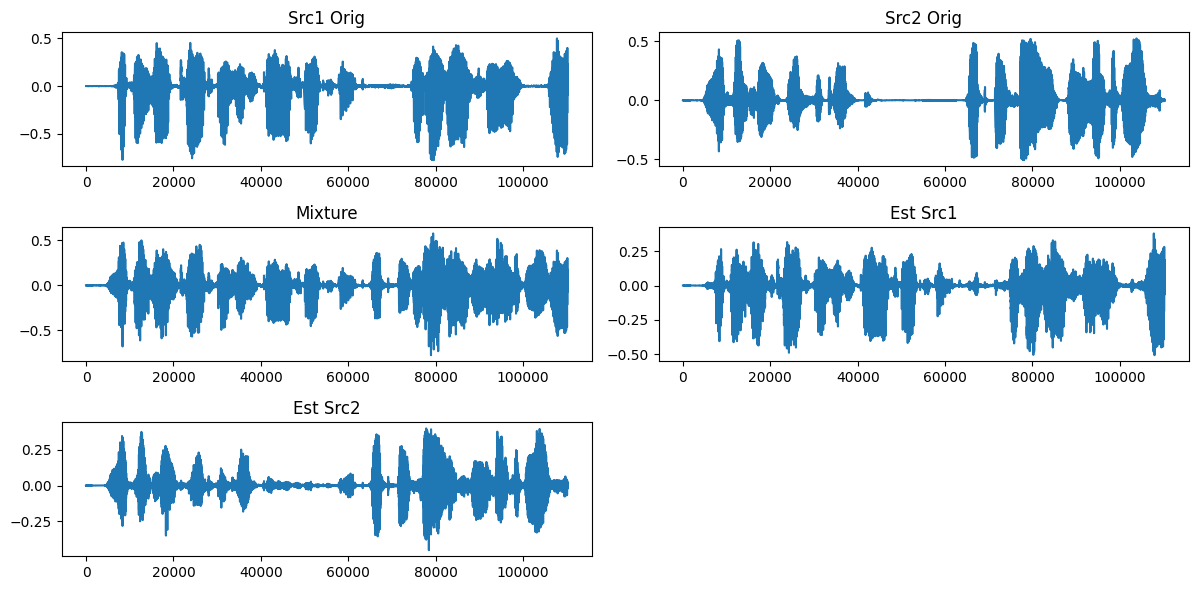

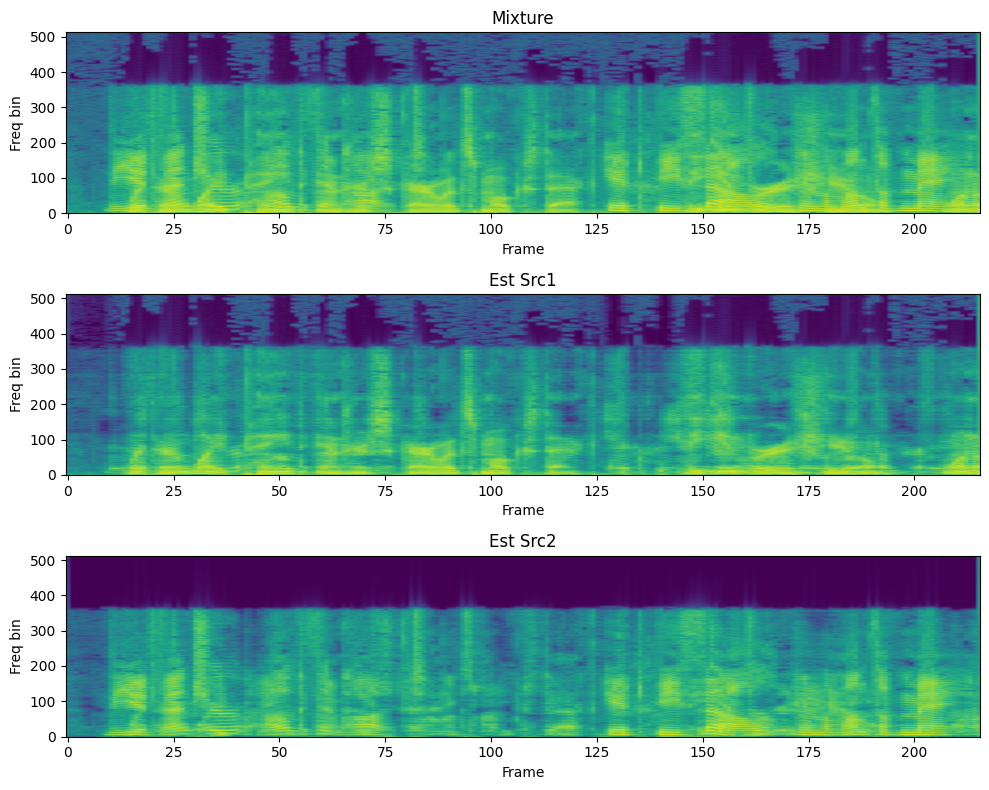

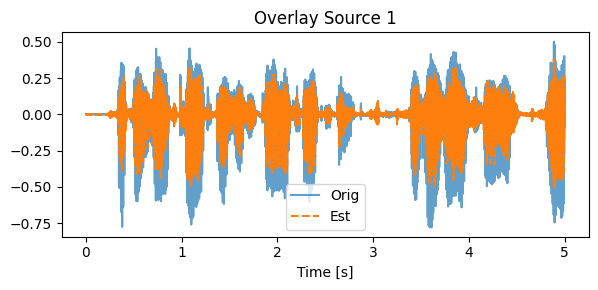

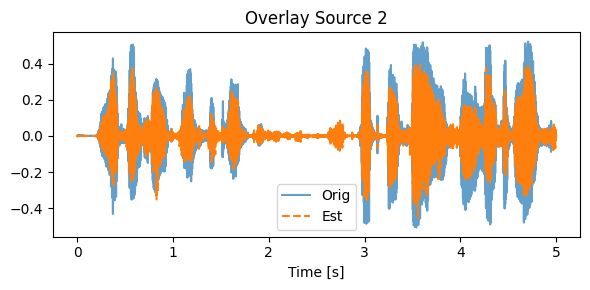

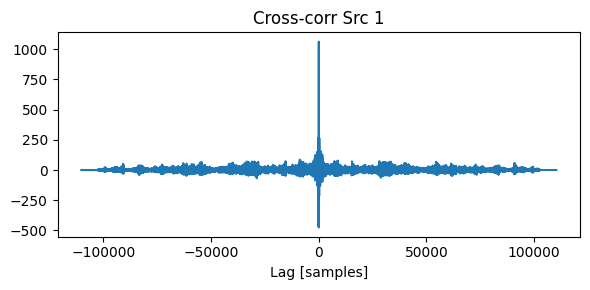

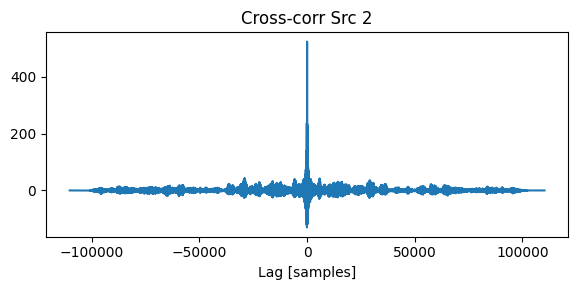

结果已保存到 c:\Users\86137\Desktop\results\nmf_separated_sup


In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from sklearn.decomposition import NMF
from scipy.signal import correlate
from mir_eval.separation import bss_eval_sources
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d
import numpy as np
import librosa

def stft(x, n_fft=1024, hop_length=None):
    """
    Compute the STFT of a 1D signal.
    """
    hop_length = hop_length or n_fft // 2
    return librosa.stft(x, n_fft=n_fft, hop_length=hop_length)


def istft(X, hop_length=None,length=None):
    """
    Inverse STFT back to time-domain signal.
    """
    hop_length = hop_length or (X.shape[0] * 2)
    return librosa.istft(X, hop_length=hop_length,length=length)


_script_dir = os.getcwd()
_src_dir = os.path.abspath(os.path.join(_script_dir, '..'))
if _src_dir not in sys.path:
    sys.path.insert(0, _src_dir)


n_fft = 1024
hop_length = 512
mix_duration = 5.0
max_iter_update = 500


def compute_spectra(x):
    D = stft(x, n_fft=n_fft, hop_length=hop_length)
    return D, np.abs(D) ** 2


def supervised_nmf(s1, s2, mix, L):
    # 1) train directory W1, W2
    D1, p1 = compute_spectra(s1)
    D2, p2 = compute_spectra(s2)
    K = 20
    nmf1 = NMF(n_components=K, init='nndsvda', solver='mu',
               beta_loss='kullback-leibler', alpha_H=0.1, max_iter=500)
    W1 = nmf1.fit_transform(p1)
    nmf2 = NMF(n_components=K, init='nndsvda', solver='mu',
               beta_loss='kullback-leibler', alpha_H=0.1, max_iter=500)
    W2 = nmf2.fit_transform(p2)
    W = np.concatenate([W1, W2], axis=1)

  
    Dmix, pmix = compute_spectra(mix)
    R, T = W.shape[1], pmix.shape[1]
    H = np.random.rand(R, T)
    for _ in range(max_iter_update):
        H *= (W.T @ (pmix / (W @ H + 1e-8))) / (W.T.sum(axis=1)[:, None] + 0.1)
    H = gaussian_filter1d(H, sigma=1.0, axis=1)

    Vs = [np.outer(W[:, i], H[i]) for i in range(R)]
    Vtot = sum(Vs) + 1e-8
    masks = [V / Vtot for V in Vs]
    phase = np.exp(1j * np.angle(Dmix))

    est1 = sum(
        istft(masks[i] * np.abs(Dmix) * phase,
              hop_length=hop_length, length=L)
        for i in range(K)
    )
    est2 = sum(
        istft(masks[i+K] * np.abs(Dmix) * phase,
              hop_length=hop_length, length=L)
        for i in range(K)
    )
    return np.vstack([est1, est2])


def main():
    
    s1, sr1 = librosa.load(librosa.example('libri1'), duration=mix_duration)
    s2, sr2 = librosa.load(librosa.example('libri2'), duration=mix_duration)
    assert sr1 == sr2
    L = min(len(s1), len(s2))
    s1, s2 = s1[:L], s2[:L]

   
    sources = np.vstack([s1, s2])
    A = np.array([[1.0, 0.5], [0.5, 1.0]])
    mix = (A @ sources).mean(axis=0)

   
    S_est = supervised_nmf(s1, s2, mix, L)

   
    sdr, sir, sar, _ = bss_eval_sources(np.vstack([s1, s2]), S_est)
    print("supervised NMF")
    for idx, (d, i_, a) in enumerate(zip(sdr, sir, sar), 1):
        print(f"  source {idx}: SDR={d:.2f} dB, SIR={i_:.2f} dB, SAR={a:.2f} dB")

    
    t = np.arange(L) / sr1
    plt.figure(figsize=(12, 6))
    labels = ['Src1 Orig', 'Src2 Orig', 'Mixture', 'Est Src1', 'Est Src2']
    signals = [s1, s2, mix, S_est[0], S_est[1]]
    for i, (sig, lbl) in enumerate(zip(signals, labels), 1):
        plt.subplot(3, 2, i)
        plt.plot(sig)
        plt.title(lbl)
        plt.tight_layout()
    plt.show()


    plt.figure(e(title)
        plt.xlabel('Frame'); plt.ylabel('Freq bin')
    plt.tight_layout()
    plt.show()

   
    for idx, (orig, est) in enumerate(zip([s1, s2], S_est), 1):
        plt.figure(figsize=(6, 3))
        plt.plot(t, orig, label='Orig', alpha=0.7)
        plt.plot(t, est, '--', label='Est')
        plt.title(f'Overlay Source {idx}')
        plt.xlabel('Time [s]'); plt.legend(); plt.tight_layout(); plt.show()

    
    for idx, (orig, est) in enumerate(zip([s1, s2], S_est), 1):
        corr = correlate(est, orig, mode='full')
        lags = np.arange(-L+1, L)
        plt.figure(figsize=(6, 3))
        plt.plot(lags, corr)
        plt.title(f'Cross-corr Src {idx}')
        plt.xlabel('Lag [samples]'); plt.tight_layout(); plt.show()
figsize=(10, 8))
    items = [(mix, 'Mixture'), (S_est[0], 'Est Src1'), (S_est[1], 'Est Src2')]
    for i, (sig, title) in enumerate(items, 1):
        plt.subplot(3, 1, i)
        D_sig, _ = compute_spectra(sig)
        plt.imshow(20 * np.log10(np.abs(D_sig) + 1e-6), origin='lower', aspect='auto')
        plt.titl
   
    out_dir = os.path.join(_src_dir, 'results', 'nmf_separated_sup')
    os.makedirs(out_dir, exist_ok=True)
    sf.write(os.path.join(out_dir, 'src1.wav'), S_est[0], sr1)
    sf.write(os.path.join(out_dir, 'src2.wav'), S_est[1], sr1)
    print(f"results saved at {out_dir}")


main()


## 3 DUET (Spectral method)

排列顺序: [1 0]
源1: SDR=18.36 dB, SIR=25.88 dB, SAR=19.21 dB
源2: SDR=9.57 dB, SIR=26.37 dB, SAR=9.68 dB


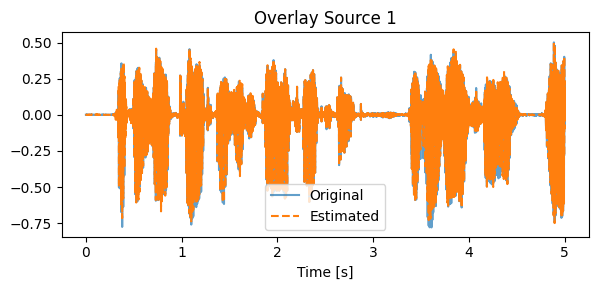

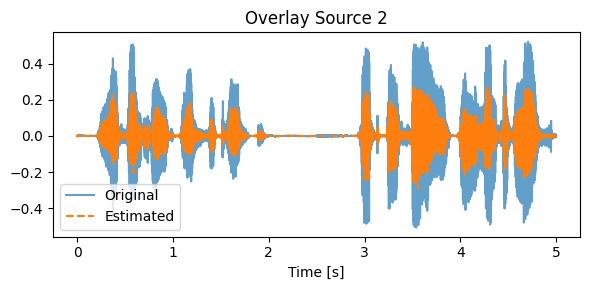

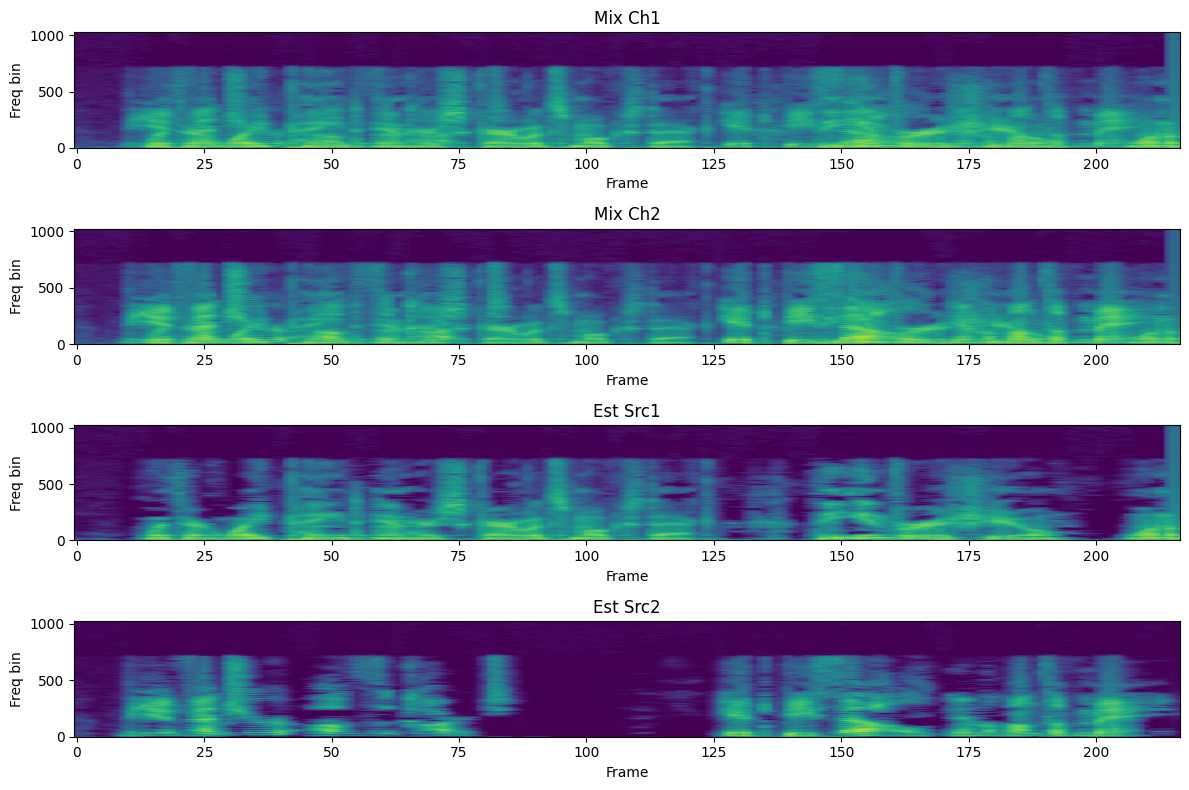

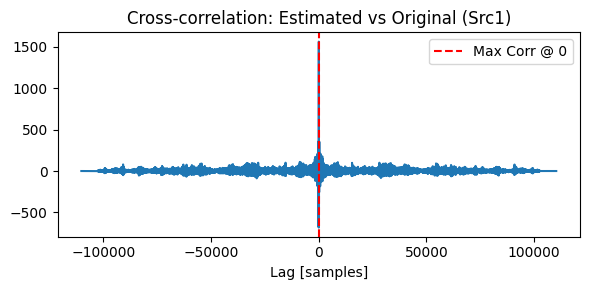

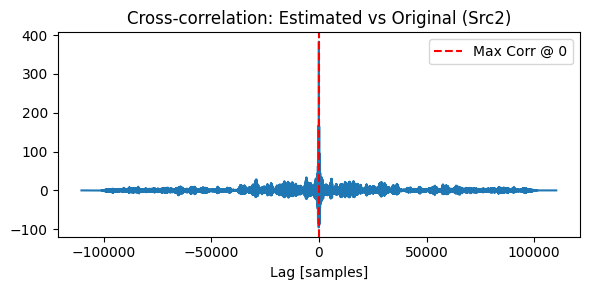

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import stft, istft, correlate
from sklearn.cluster import KMeans
from mir_eval.separation import bss_eval_sources
import warnings


n_fft = 2048
hop_length = 512
win_length = n_fft


def duet_separation(mix, sr):
    assert mix.ndim == 2 and mix.shape[0] == 2

    # STFT
    _, _, Z_l = stft(mix[0], fs=sr, nperseg=win_length, noverlap=win_length - hop_length)
    _, _, Z_r = stft(mix[1], fs=sr, nperseg=win_length, noverlap=win_length - hop_length)

    
    mag_l, mag_r = np.abs(Z_l), np.abs(Z_r)
    phase_l, phase_r = np.angle(Z_l), np.angle(Z_r)
    a = mag_r / (mag_l + 1e-8)
    delta = phase_r - phase_l
    features = np.stack([a.flatten(), np.cos(delta).flatten(), np.sin(delta).flatten()], axis=1)

    
    kmeans = KMeans(n_clusters=2, n_init=10).fit(features)
    labels = kmeans.labels_.reshape(a.shape)

   
    masks = [(labels == i) for i in range(2)]
    estimates = [istft(Z_l * mask.astype(float), fs=sr, nperseg=win_length, noverlap=win_length - hop_length)[1] for mask in masks]
    min_len = min(len(e) for e in estimates)
    return [e[:min_len] for e in estimates]


def compute_spectra(x, sr):
    _, _, D = stft(x, fs=sr, nperseg=n_fft, noverlap=n_fft - hop_length)
    return D, np.abs(D) ** 2


def align_estimates(estimates, references):
   
    min_len = min(min(len(e) for e in estimates), min(len(r) for r in references))
    estimates = [e[:min_len] for e in estimates]
    references = [r[:min_len] for r in references]

    # ignore deprecated warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sdr, sir, sar, perm = bss_eval_sources(np.array(references), np.array(estimates))

    aligned = [estimates[i] for i in perm]
    return aligned, (sdr, sir, sar), perm


if __name__ == "__main__":
   
    s1, sr = librosa.load(librosa.example('libri1'), duration=5.0)
    s2, _  = librosa.load(librosa.example('libri2'), duration=5.0)
    L = min(len(s1), len(s2))
    s1, s2 = s1[:L], s2[:L]
    sources = np.vstack([s1, s2])

  
    A = np.array([[1.0, 0.5], [0.5, 1.0]])
    X = A @ sources  # shape = (2, L)

    # DUET
    estimates = duet_separation(X, sr)

    
    estimates_aligned, (sdr, sir, sar), perm = align_estimates(estimates, [s1, s2])
    print("range:", perm)
    for i in range(2):
        print(f"source{i+1}: SDR={sdr[i]:.2f} dB, SIR={sir[i]:.2f} dB, SAR={sar[i]:.2f} dB")

   
    sf.write("estimated1.wav", estimates_aligned[0], sr)
    sf.write("estimated2.wav", estimates_aligned[1], sr)

   
    t = np.arange(L) / sr
    for idx, (orig, est) in enumerate(zip([s1, s2], estimates_aligned), 1):
        min_len = min(len(orig), len(est))
        plt.figure(figsize=(6, 3))
        plt.plot(t[:min_len], orig[:min_len], label='Original', alpha=0.7)
        plt.plot(t[:min_len], est[:min_len], '--', label='Estimated')
        plt.title(f'Overlay Source {idx}')
        plt.xlabel('Time [s]')
        plt.legend()
        plt.tight_layout()
        plt.show()

    
    items = [(X[0], 'Mix Ch1'), (X[1], 'Mix Ch2'), (estimates_aligned[0], 'Est Src1'), (estimates_aligned[1], 'Est Src2')]
    plt.figure(figsize=(12, 8))
    for i, (sig, title) in enumerate(items, 1):
        D, _ = compute_spectra(sig, sr)
        plt.subplot(4, 1, i)
        plt.imshow(20 * np.log10(np.abs(D) + 1e-6), origin='lower', aspect='auto')
        plt.title(title)
        plt.xlabel('Frame')
        plt.ylabel('Freq bin')
    plt.tight_layout()
    plt.show()

    
    for idx, (orig, est) in enumerate(zip([s1, s2], estimates_aligned), 1):
        min_len = min(len(orig), len(est))
        corr = correlate(est[:min_len], orig[:min_len], mode='full')
        lags = np.arange(-min_len + 1, min_len)
        plt.figure(figsize=(6, 3))
        plt.plot(lags, corr)
        max_lag = lags[np.argmax(np.abs(corr))]
        plt.axvline(max_lag, color='r', linestyle='--', label=f'Max Corr @ {max_lag}')
        plt.title(f'Cross-correlation: Estimated vs Original (Src{idx})')
        plt.xlabel('Lag [samples]')
        plt.legend()
        plt.tight_layout()
        plt.show()



# 🎧 Blind Source Separation (BSS) multi-prople

# 1 FastICA 

ICA 分离评估指标（已排列）:
  源 1: SDR=37.95 dB, SIR=37.96 dB, SAR=62.45 dB
  源 2: SDR=39.38 dB, SIR=39.43 dB, SAR=58.75 dB
  源 3: SDR=38.38 dB, SIR=38.68 dB, SAR=50.19 dB


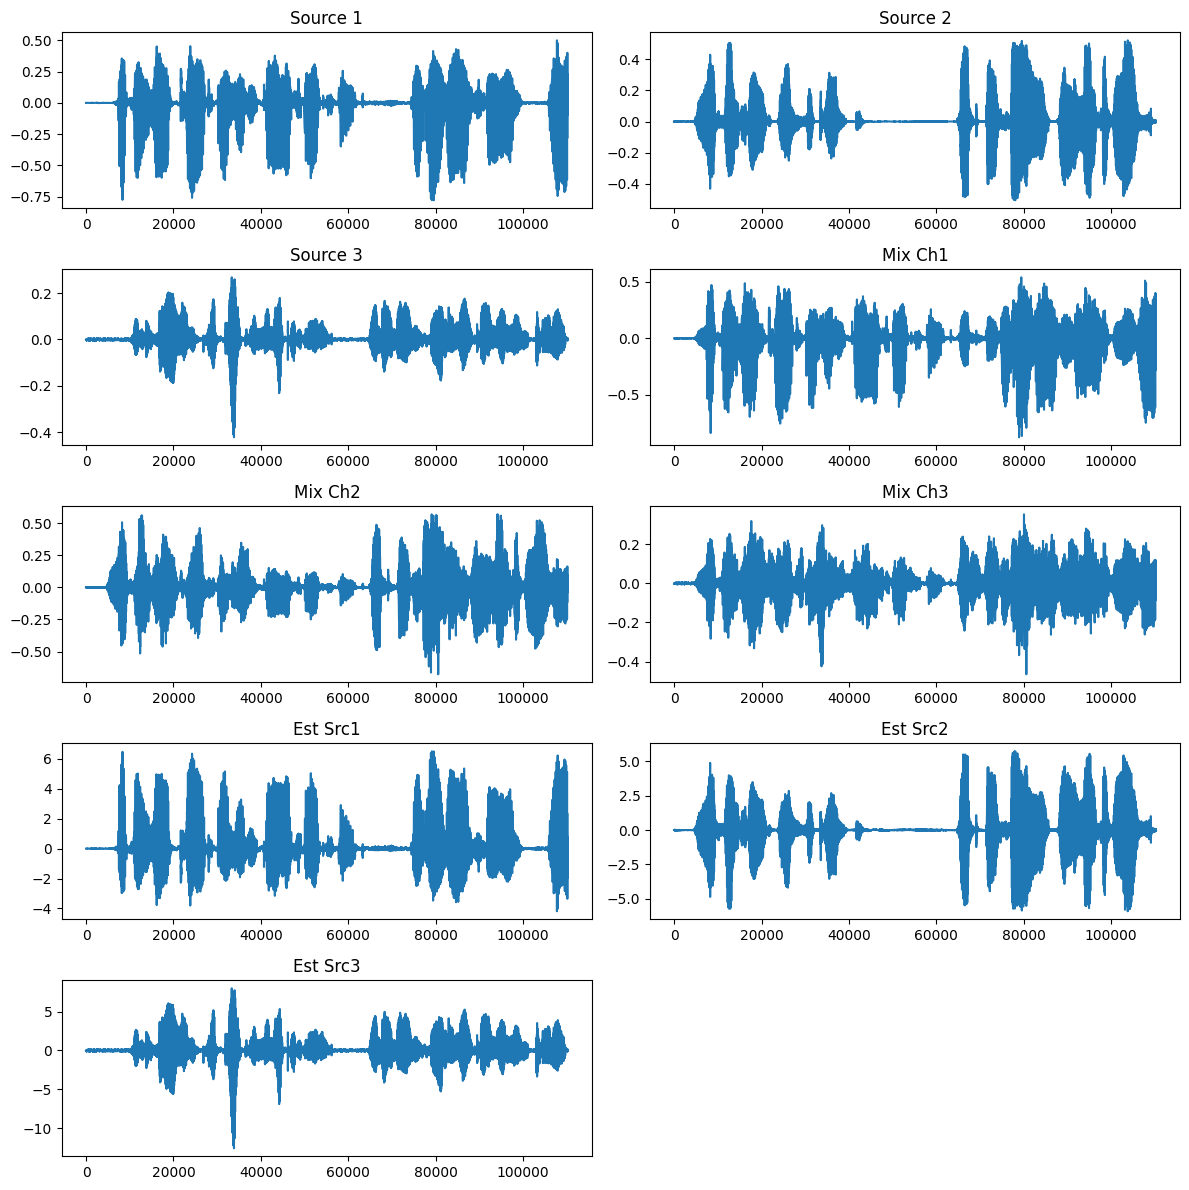

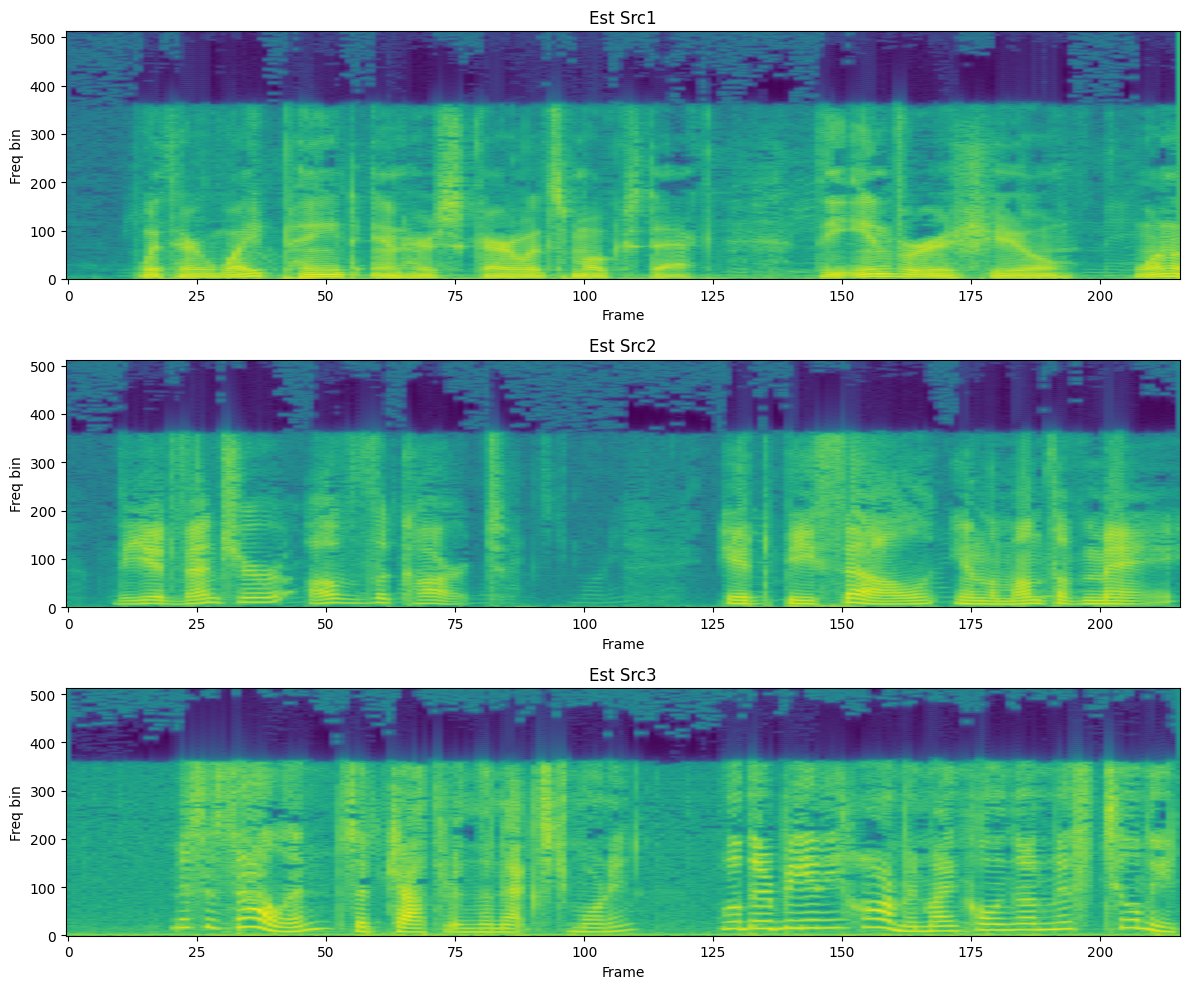

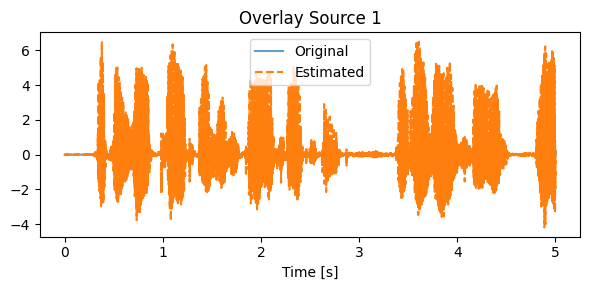

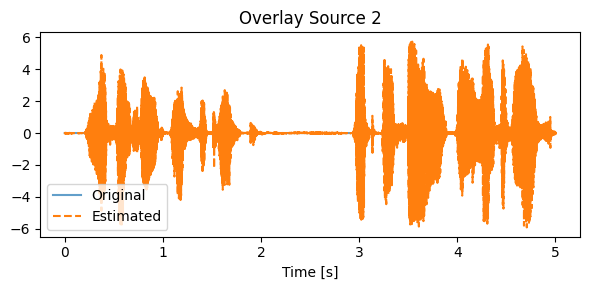

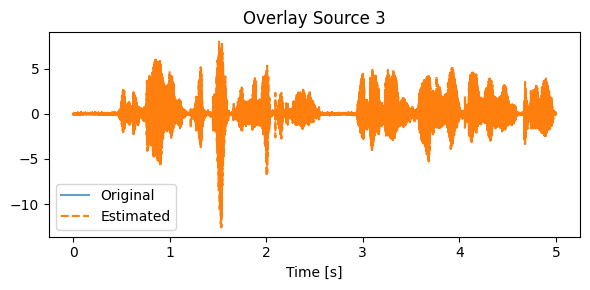

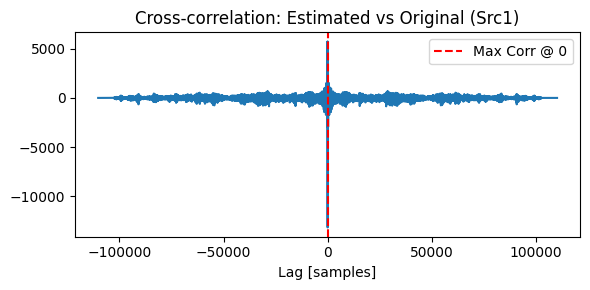

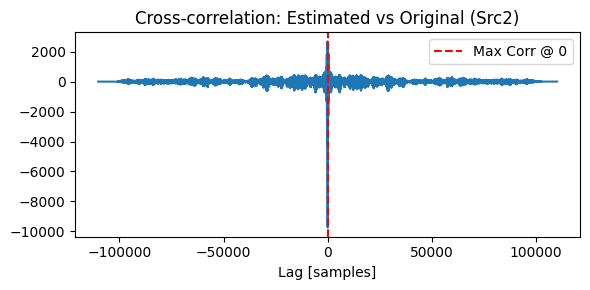

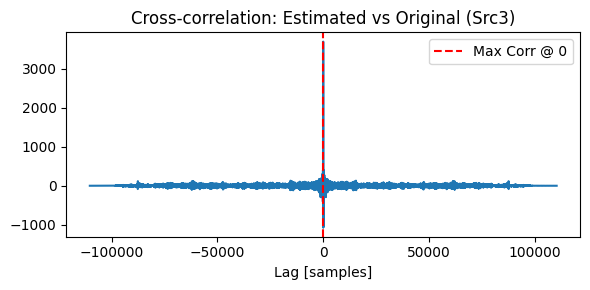

已保存混合信号与分离结果至 c:\Users\86137\Desktop\123project\results\separated_3src


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from sklearn.decomposition import FastICA
from mir_eval.separation import bss_eval_sources
import os
from scipy.signal import correlate
import warnings

def stft(x, n_fft=1024, hop_length=None):
    hop_length = hop_length or n_fft // 2
    return librosa.stft(x, n_fft=n_fft, hop_length=hop_length)

def istft(X, hop_length=None):
    hop_length = hop_length or (X.shape[0] * 2)
    return librosa.istft(X, hop_length=hop_length)

def main():
   
    s1, sr = librosa.load(librosa.example('libri1'), duration=5.0)
    s2, _ = librosa.load(librosa.example('libri2'), duration=5.0)
    s3, _ = librosa.load(librosa.example('libri3'), duration=5.0)

    L = min(len(s1), len(s2), len(s3))
    s1, s2, s3 = s1[:L], s2[:L], s3[:L]
    sources = np.vstack([s1, s2, s3])  # shape = (3, L)

   
    A = np.array([[1.0, 0.5, 0.2],
                  [0.4, 1.0, 0.3],
                  [0.3, 0.4, 1.0]])
    X = A @ sources  # shape = (3, L)

    
    ica = FastICA(n_components=3, random_state=0)
    S_est = ica.fit_transform(X.T).T  # shape = (3, L)

 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sdr, sir, sar, perm = bss_eval_sources(sources, S_est)

    S_est = [S_est[i] for i in perm] 
    print("ICA evaluation:")
    for i, (sdr_i, sir_i, sar_i) in enumerate(zip(sdr, sir, sar), 1):
        print(f" source {i}: SDR={sdr_i:.2f} dB, SIR={sir_i:.2f} dB, SAR={sar_i:.2f} dB")

    
    titles = ['Source 1', 'Source 2', 'Source 3',
              'Mix Ch1', 'Mix Ch2', 'Mix Ch3',
              'Est Src1', 'Est Src2', 'Est Src3']
    signals = [s1, s2, s3, X[0], X[1], X[2], S_est[0], S_est[1], S_est[2]]
    plt.figure(figsize=(12, 12))
    for idx, sig in enumerate(signals, 1):
        plt.subplot(5, 2, idx)
        plt.plot(sig)
        plt.title(titles[idx - 1])
        plt.tight_layout()
    plt.show()

    
    plt.figure(figsize=(12, 10))
    for idx, (sig, title) in enumerate(zip(S_est, ['Est Src1', 'Est Src2', 'Est Src3']), 1):
        D = stft(sig, n_fft=1024, hop_length=512)
        plt.subplot(3, 1, idx)
        plt.imshow(20 * np.log10(np.abs(D) + 1e-6), origin='lower', aspect='auto')
        plt.title(title)
        plt.ylabel('Freq bin')
        plt.xlabel('Frame')
    plt.tight_layout()
    plt.show()

    
    t = np.arange(L) / sr
    for idx, (orig, est) in enumerate(zip([s1, s2, s3], S_est), 1):
        min_len = min(len(orig), len(est))
        plt.figure(figsize=(6, 3))
        plt.plot(t[:min_len], orig[:min_len], label='Original', alpha=0.7)
        plt.plot(t[:min_len], est[:min_len], '--', label='Estimated')
        plt.title(f'Overlay Source {idx}')
        plt.xlabel('Time [s]')
        plt.legend()
        plt.tight_layout()
        plt.show()

    #  Cross-correlation
    for idx, (orig, est) in enumerate(zip([s1, s2, s3], S_est), 1):
        min_len = min(len(orig), len(est))
        corr = correlate(est[:min_len], orig[:min_len], mode='full')
        lags = np.arange(-min_len + 1, min_len)
        plt.figure(figsize=(6, 3))
        plt.plot(lags, corr)
        max_lag = lags[np.argmax(np.abs(corr))]
        plt.axvline(max_lag, color='r', linestyle='--', label=f'Max Corr @ {max_lag}')
        plt.title(f'Cross-correlation: Estimated vs Original (Src{idx})')
        plt.xlabel('Lag [samples]')
        plt.legend()
        plt.tight_layout()
        plt.show()

    
    out_dir = os.path.abspath(os.path.join('.', 'results', 'separated_3src'))
    os.makedirs(out_dir, exist_ok=True)
    for i in range(3):
        sf.write(os.path.join(out_dir, f'ICA_src{i+1}.wav'), S_est[i], sr)
        sf.write(os.path.join(out_dir, f'Mix_ch{i+1}.wav'), X[i], sr)

    print(f"saved at {out_dir}")

main()


# 2 NMF

C:\Users\86137\AppData\Local\Temp\ipykernel_23568\3148528682.py:84: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = bss_eval_sources(sources, S_est)


三源监督式 NMF 分离评估：
  源 1: SDR=13.58 dB, SIR=19.44 dB, SAR=14.94 dB
  源 2: SDR=1.48 dB, SIR=6.47 dB, SAR=4.02 dB
  源 3: SDR=-8.61 dB, SIR=-3.84 dB, SAR=-1.50 dB


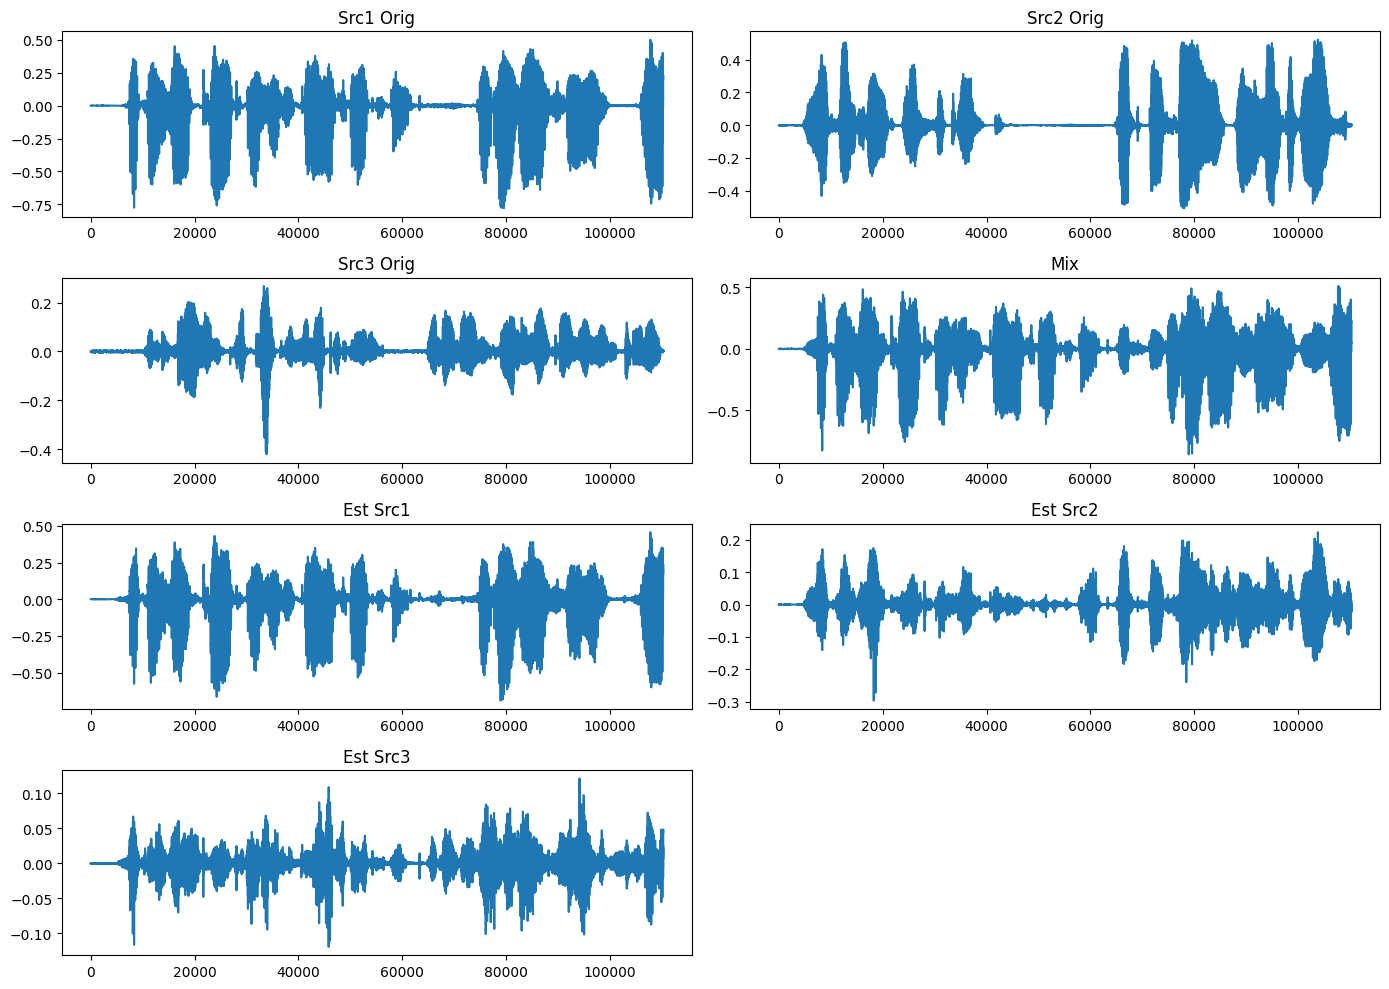

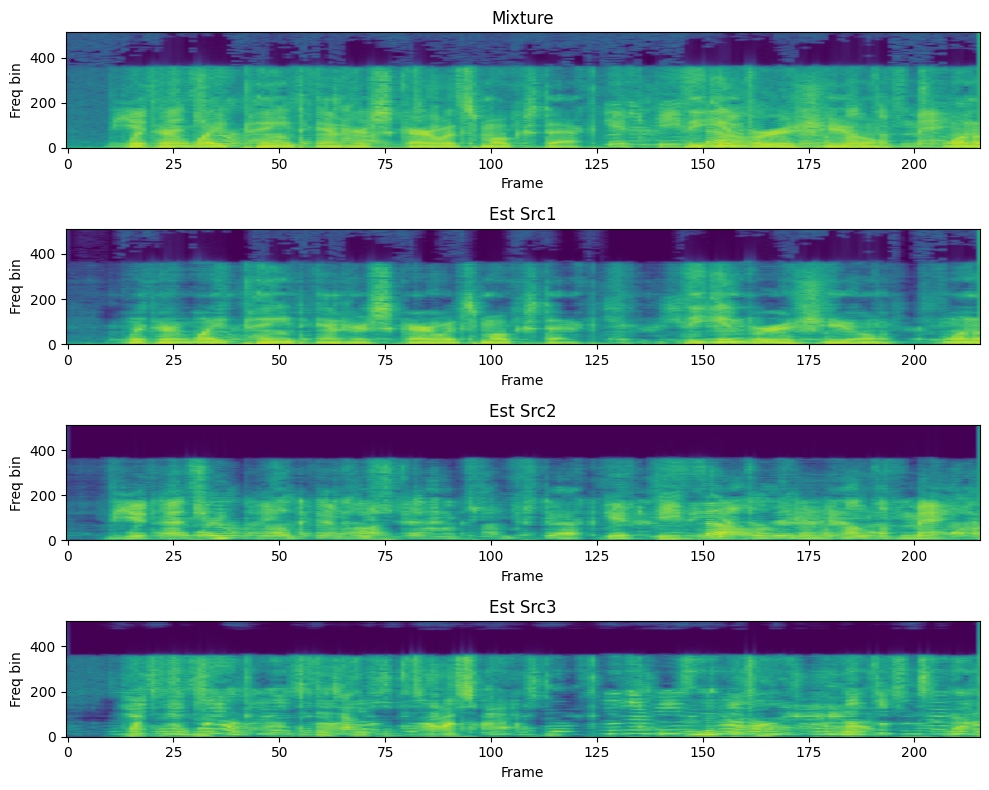

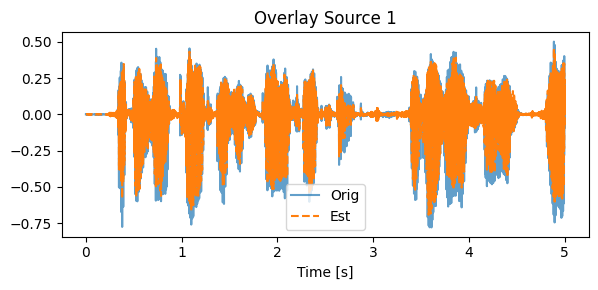

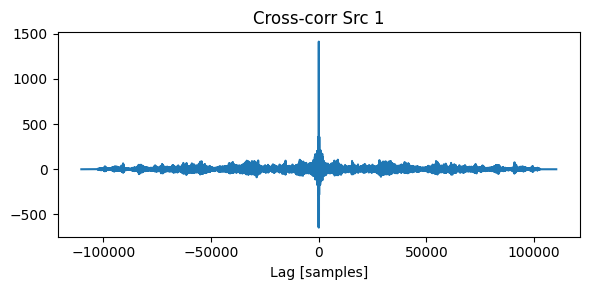

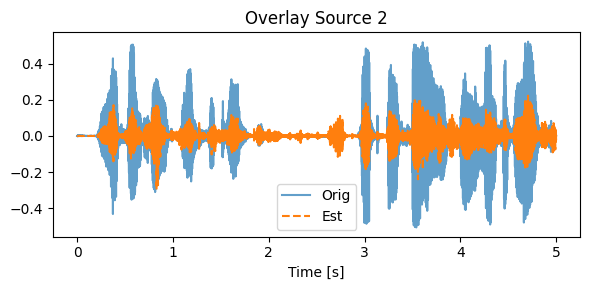

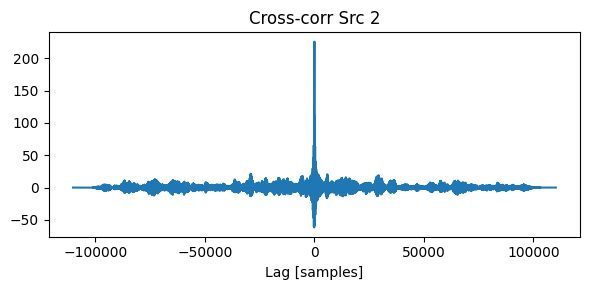

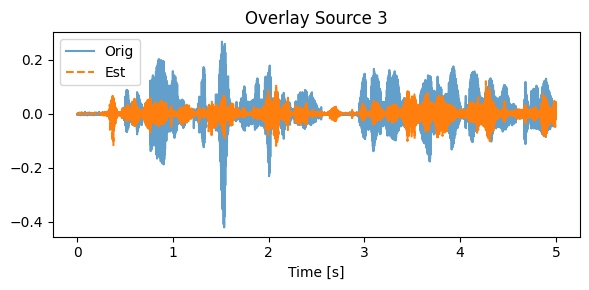

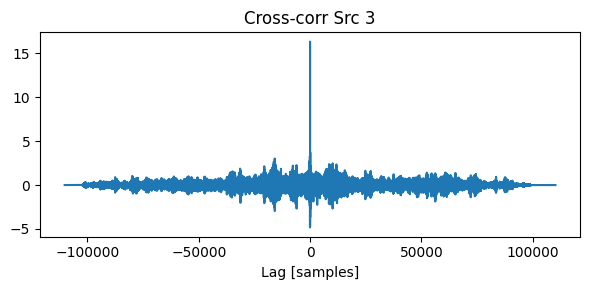

混合信号和分离结果已保存到 .\results\nmf_sup_3src


In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from sklearn.decomposition import NMF
from scipy.signal import correlate
from mir_eval.separation import bss_eval_sources
from scipy.ndimage import gaussian_filter1d

def stft(x, n_fft=1024, hop_length=None):
    hop_length = hop_length or n_fft // 2
    return librosa.stft(x, n_fft=n_fft, hop_length=hop_length)

def istft(X, hop_length=None, length=None):
    hop_length = hop_length or (X.shape[0] * 2)
    return librosa.istft(X, hop_length=hop_length, length=length)


n_fft = 1024
hop_length = 512
mix_duration = 5.0
max_iter_update = 500
K = 20

def compute_spectra(x):
    D = stft(x, n_fft=n_fft, hop_length=hop_length)
    return D, np.abs(D) ** 2

def supervised_nmf_3src(sources, mix, L):
    W_list = []
    for i in range(3):
        _, p = compute_spectra(sources[i])
        nmf = NMF(n_components=K, init='nndsvda', solver='mu',
                  beta_loss='kullback-leibler', alpha_H=0.1, max_iter=500)
        W = nmf.fit_transform(p)
        W_list.append(W)

    W_all = np.concatenate(W_list, axis=1)
    Dmix, pmix = compute_spectra(mix)
    R, T = W_all.shape[1], pmix.shape[1]
    H = np.random.rand(R, T)

    for _ in range(max_iter_update):
        H *= (W_all.T @ (pmix / (W_all @ H + 1e-8))) / (W_all.T.sum(axis=1)[:, None] + 0.1)
    H = gaussian_filter1d(H, sigma=1.0, axis=1)

    Vs = [np.outer(W_all[:, i], H[i]) for i in range(R)]
    Vtot = sum(Vs) + 1e-8
    masks = [V / Vtot for V in Vs]
    phase = np.exp(1j * np.angle(Dmix))

    ests = []
    for j in range(3):
        est_j = sum(
            istft(masks[i] * np.abs(Dmix) * phase,
                  hop_length=hop_length, length=L)
            for i in range(j * K, (j + 1) * K)
        )
        ests.append(est_j)
    return np.vstack(ests)  # shape = (3, L)

def main():
    
    s1, sr = librosa.load(librosa.example('libri1'), duration=mix_duration)
    s2, _  = librosa.load(librosa.example('libri2'), duration=mix_duration)
    s3, _  = librosa.load(librosa.example('libri3'), duration=mix_duration)
    L = min(len(s1), len(s2), len(s3))
    s1, s2, s3 = s1[:L], s2[:L], s3[:L]
    sources = np.vstack([s1, s2, s3])  # shape = (3, L)

   
    A = np.array([[1.0, 0.4, 0.3],
                  [0.3, 1.0, 0.4],
                  [0.4, 0.3, 1.0]])
    mix_all = A @ sources  # shape = (3, L)
    mix = mix_all[0]       

    
    S_est = supervised_nmf_3src(sources, mix, L)

    
    sdr, sir, sar, _ = bss_eval_sources(sources, S_est)
    print("three-source supervised NMF:")
    for idx, (d, i_, a) in enumerate(zip(sdr, sir, sar), 1):
        print(f"  source {idx}: SDR={d:.2f} dB, SIR={i_:.2f} dB, SAR={a:.2f} dB")

    
    t = np.arange(L) / sr
    labels = ['Src1 Orig', 'Src2 Orig', 'Src3 Orig', 'Mix', 'Est Src1', 'Est Src2', 'Est Src3']
    signals = [s1, s2, s3, mix, S_est[0], S_est[1], S_est[2]]
    plt.figure(figsize=(14, 10))
    for i, (sig, lbl) in enumerate(zip(signals, labels), 1):
        plt.subplot(4, 2, i)
        plt.plot(sig)
        plt.title(lbl)
        plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(10, 8))
    items = [(mix, 'Mixture')] + [(S_est[i], f'Est Src{i+1}') for i in range(3)]
    for i, (sig, title) in enumerate(items, 1):
        plt.subplot(4, 1, i)
        D_sig, _ = compute_spectra(sig)
        plt.imshow(20 * np.log10(np.abs(D_sig) + 1e-6), origin='lower', aspect='auto')
        plt.title(title)
        plt.xlabel('Frame'); plt.ylabel('Freq bin')
    plt.tight_layout()
    plt.show()

    
    for idx, (orig, est) in enumerate(zip([s1, s2, s3], S_est), 1):
        plt.figure(figsize=(6, 3))
        plt.plot(t, orig, label='Orig', alpha=0.7)
        plt.plot(t, est, '--', label='Est')
        plt.title(f'Overlay Source {idx}')
        plt.xlabel('Time [s]'); plt.legend(); plt.tight_layout(); plt.show()

        corr = correlate(est, orig, mode='full')
        lags = np.arange(-L+1, L)
        plt.figure(figsize=(6, 3))
        plt.plot(lags, corr)
        plt.title(f'Cross-corr Src {idx}')
        plt.xlabel('Lag [samples]'); plt.tight_layout(); plt.show()

    
    out_dir = os.path.join('.', 'results', 'nmf_sup_3src')
    os.makedirs(out_dir, exist_ok=True)
    for i in range(3):
        sf.write(os.path.join(out_dir, f'est_src{i+1}.wav'), S_est[i], sr)
        sf.write(os.path.join(out_dir, f'mix_ch{i+1}.wav'), mix_all[i], sr)
    print(f"saved at {out_dir}")

main()


# 3 DUET

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import stft, istft, correlate
from sklearn.cluster import KMeans
from mir_eval.separation import bss_eval_sources
from skimage.metrics import structural_similarity as ssim  # SSIM
import warnings


n_fft = 2048
hop_length = 512
win_length = n_fft


def duet_separation(mix, sr):
    assert mix.ndim == 2 and mix.shape[0] == 2

    # STFT
    _, _, Z_l = stft(mix[0], fs=sr, nperseg=win_length, noverlap=win_length - hop_length)
    _, _, Z_r = stft(mix[1], fs=sr, nperseg=win_length, noverlap=win_length - hop_length)

 
    mag_l, mag_r = np.abs(Z_l), np.abs(Z_r)
    phase_l, phase_r = np.angle(Z_l), np.angle(Z_r)
    a = mag_r / (mag_l + 1e-8)
    delta = phase_r - phase_l
    features = np.stack([a.flatten(), np.cos(delta).flatten(), np.sin(delta).flatten()], axis=1)

    
    kmeans = KMeans(n_clusters=2, n_init=10).fit(features)
    labels = kmeans.labels_.reshape(a.shape)

    
    masks = [(labels == i) for i in range(2)]
    estimates = [istft(Z_l * mask.astype(float), fs=sr, nperseg=win_length, noverlap=win_length - hop_length)[1] for mask in masks]
    min_len = min(len(e) for e in estimates)
    return [e[:min_len] for e in estimates]


def compute_spectra(x, sr):
    _, _, D = stft(x, fs=sr, nperseg=n_fft, noverlap=n_fft - hop_length)
    return D, np.abs(D) ** 2


def align_estimates(estimates, references):
    min_len = min(min(len(e) for e in estimates), min(len(r) for r in references))
    estimates = [e[:min_len] for e in estimates]
    references = [r[:min_len] for r in references]
    sdr, sir, sar, perm = bss_eval_sources(np.array(references), np.array(estimates))
    aligned = [estimates[i] for i in perm]
    return aligned, [r[:min_len] for r in references], (sdr, sir, sar), perm


def compute_snr(reference, estimate):
    noise = reference - estimate
    return 10 * np.log10(np.sum(reference**2) / (np.sum(noise**2) + 1e-10))


if __name__ == "__main__":
  
    s1, sr = librosa.load(librosa.example('libri1'), duration=5.0)
    s2, _  = librosa.load(librosa.example('libri2'), duration=5.0)
    L = min(len(s1), len(s2))
    s1, s2 = s1[:L], s2[:L]
    sources = np.vstack([s1, s2])

    A = np.array([[1.0, 0.5], [0.5, 1.0]])
    X = A @ sources  # shape = (2, L)


    estimates = duet_separation(X, sr)


    estimates_aligned, references_aligned, (sdr, sir, sar), perm = align_estimates(estimates, [s1, s2])
    print("sequence:", perm)
    for i in range(2):
        print(f"source{i+1}: SDR={sdr[i]:.2f} dB, SIR={sir[i]:.2f} dB, SAR={sar[i]:.2f} dB")

   
    for idx, (orig, est) in enumerate(zip(references_aligned, estimates_aligned), 1):
        min_len = min(len(orig), len(est))
        orig, est = orig[:min_len], est[:min_len]
        snr_val = compute_snr(orig, est)
        mse_val = np.mean((orig - est) ** 2)
        ssim_val = ssim(orig, est, data_range=est.max() - est.min())

        print(f"source{idx}: SNR={snr_val:.2f} dB, MSE={mse_val:.6f}, SSIM={ssim_val:.4f}")

        
        t = np.arange(min_len) / sr
        plt.figure(figsize=(8, 3))
        plt.plot(t, orig, label='Original', alpha=0.7)
        plt.plot(t, est, '--', label='Estimated')
        plt.title(f'Overlay Source {idx} - SNR: {snr_val:.2f}dB, MSE: {mse_val:.4e}, SSIM: {ssim_val:.4f}')
        plt.xlabel('Time [s]')
        plt.legend()
        plt.tight_layout()
        plt.show()

     
        corr = correlate(est, orig, mode='full')
        lags = np.arange(-min_len + 1, min_len)
        plt.figure(figsize=(6, 3))
        plt.plot(lags, corr)
        max_lag = lags[np.argmax(np.abs(corr))]
        plt.axvline(max_lag, color='r', linestyle='--', label=f'Max Corr @ {max_lag}')
        plt.title(f'Cross-correlation: Estimated vs Original (Src{idx})')
        plt.xlabel('Lag [samples]')
        plt.legend()
        plt.tight_layout()
        plt.show()

    
    items = [(X[0], 'Mix Ch1'), (X[1], 'Mix Ch2'), (estimates_aligned[0], 'Est Src1'), (estimates_aligned[1], 'Est Src2')]
    plt.figure(figsize=(12, 8))
    for i, (sig, title) in enumerate(items, 1):
        D, _ = compute_spectra(sig, sr)
        plt.subplot(4, 1, i)
        plt.imshow(20 * np.log10(np.abs(D) + 1e-6), origin='lower', aspect='auto')
        plt.title(title)
        plt.xlabel('Frame')
        plt.ylabel('Freq bin')
    plt.tight_layout()
    plt.show()

    
    sf.write("estimated1.wav", estimates_aligned[0], sr)
    sf.write("estimated2.wav", estimates_aligned[1], sr)
